In [631]:
# 绘制聚类结果
import matplotlib.pyplot as plt

# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

In [632]:
import pandas as pd

# 读取数据
df = pd.read_csv('./pre_process/data_processed_male.csv')

In [633]:
# 1. 筛选男胎孕妇（Y染色体浓度非空，BMI非空）
df = df[(df['Y染色体浓度'].notna()) & (df['孕妇BMI'].notna())].copy()

df['BMI'] = df['孕妇BMI'].astype(float)  # 确保BMI是float类型

In [634]:
df = df[['孕妇代码', '检测孕周_周数', 'BMI','Y染色体浓度']]
df

,孕妇代码,检测孕周_周数,BMI,Y染色体浓度
0,A001,11.857143,28.125000,0.025936
1,A001,15.857143,28.515625,0.034887
2,A001,20.142857,28.515625,0.066171
3,A001,22.857143,28.906250,0.061192
4,A002,13.857143,33.331832,0.059230
...,...,...,...,...
882,A266,17.714286,32.969881,0.099052
883,A267,11.571429,30.703133,0.098706
884,A267,12.571429,30.825814,0.102088
885,A267,13.571429,31.107551,0.109855


## 平滑插值

问题：部分数据空格很大

In [635]:

def show_plts(df):
    # 选择5个孕妇（如果数据多，可以用 sample）
    selected_codes = df['孕妇代码'].unique()[:5]
    df_selected = df[df['孕妇代码'].isin(selected_codes)]
    # 绘制 Y染色体浓度 vs 孕周
    plt.figure(figsize=(8, 5))
    for code, group in df_selected.groupby('孕妇代码'):
        plt.plot(group['检测孕周_周数'], group['Y染色体浓度'], marker='o', label=code)
    plt.xlabel('检测孕周（周）')
    plt.ylabel('Y染色体浓度')
    plt.title('Y染色体浓度随孕周变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # 绘制 BMI vs 孕周
    plt.figure(figsize=(8, 5))
    for code, group in df_selected.groupby('孕妇代码'):
        plt.plot(group['检测孕周_周数'], group['BMI'], marker='o', label=code)
    plt.xlabel('检测孕周（周）')
    plt.ylabel('BMI')
    plt.title('BMI随孕周变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


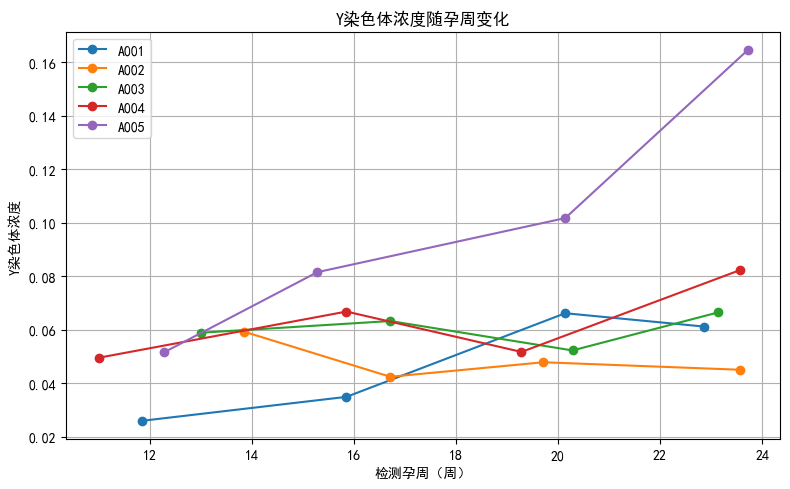

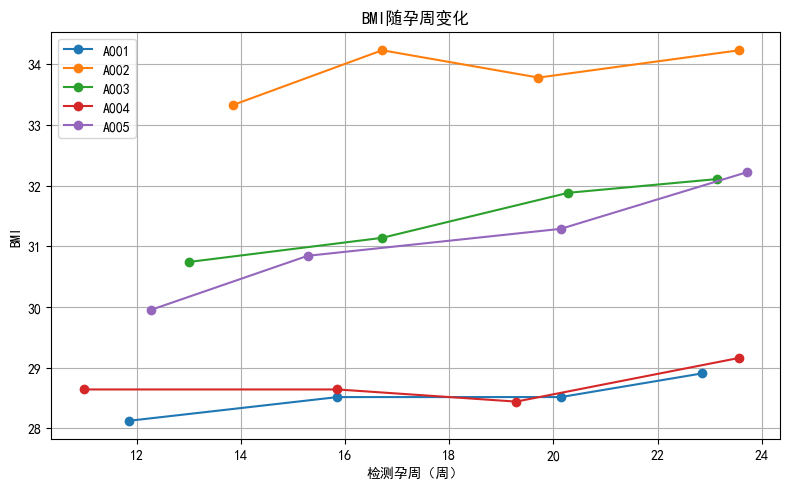

In [636]:
show_plts(df)

### 计算插值

In [637]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# 确保排序
df = df.sort_values(['孕妇代码', '检测孕周_周数'])

def smooth_interpolate(group, step=0.5, extend_before=1.0, extend_after=1.0):
    pid = group['孕妇代码'].iloc[0]
    
    # 按孕周排序
    group = group.sort_values('检测孕周_周数')
    
    # 如果有重复孕周，取均值
    group = group.groupby('检测孕周_周数', as_index=False).agg({
        'BMI': 'mean',
        'Y染色体浓度': 'mean'
    })
    
    weeks = group['检测孕周_周数'].values
    bmi = group['BMI'].values
    y_chr = group['Y染色体浓度'].values
    
    if len(weeks) < 2:
        group['孕妇代码'] = pid
        return group[['孕妇代码', '检测孕周_周数', 'BMI', 'Y染色体浓度']]
    
    # 生成扩展后的孕周序列
    start_week = max(0, weeks.min() - extend_before)  # 保证不小于0
    end_week = weeks.max() + extend_after
    full_weeks = np.arange(start_week, end_week + step, step)
    
    # 三次样条插值 + 外推
    bmi_spline = CubicSpline(weeks, bmi, extrapolate=True)
    y_spline = CubicSpline(weeks, y_chr, extrapolate=True)
    
    return pd.DataFrame({
        '孕妇代码': pid,
        '检测孕周_周数': full_weeks,
        'BMI': bmi_spline(full_weeks),
        'Y染色体浓度': y_spline(full_weeks)
    })

# 分组插值
result_df = df.groupby('孕妇代码', group_keys=False).apply(
    smooth_interpolate, step=0.4, extend_before=0.8, extend_after=0.8
).reset_index(drop=True)

print(result_df.head(20))


    孕妇代码    检测孕周_周数        BMI    Y染色体浓度
0   A001  11.057143  27.899025  0.032568
1   A001  11.457143  28.020243  0.028778
2   A001  11.857143  28.125000  0.025936
3   A001  12.257143  28.214425  0.023974
4   A001  12.657143  28.289647  0.022825
5   A001  13.057143  28.351796  0.022422
6   A001  13.457143  28.402000  0.022699
7   A001  13.857143  28.441389  0.023589
8   A001  14.257143  28.471092  0.025024
9   A001  14.657143  28.492238  0.026939
10  A001  15.057143  28.505956  0.029265
11  A001  15.457143  28.513375  0.031937
12  A001  15.857143  28.515625  0.034887
13  A001  16.257143  28.513834  0.038048
14  A001  16.657143  28.509133  0.041354
15  A001  17.057143  28.502649  0.044738
16  A001  17.457143  28.495512  0.048132
17  A001  17.857143  28.488851  0.051470
18  A001  18.257143  28.483796  0.054686
19  A001  18.657143  28.481475  0.057711


C:\Users\heerh\AppData\Local\Temp\ipykernel_18872\3865717913.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('孕妇代码', group_keys=False).apply(


In [638]:
result_df

,孕妇代码,检测孕周_周数,BMI,Y染色体浓度
0,A001,11.057143,27.899025,0.032568
1,A001,11.457143,28.020243,0.028778
2,A001,11.857143,28.125000,0.025936
3,A001,12.257143,28.214425,0.023974
4,A001,12.657143,28.289647,0.022825
...,...,...,...,...
5848,A267,13.971429,31.270157,0.114337
5849,A267,14.371429,31.463587,0.119670
5850,A267,14.771429,31.689377,0.125895
5851,A267,15.171429,31.949062,0.133054


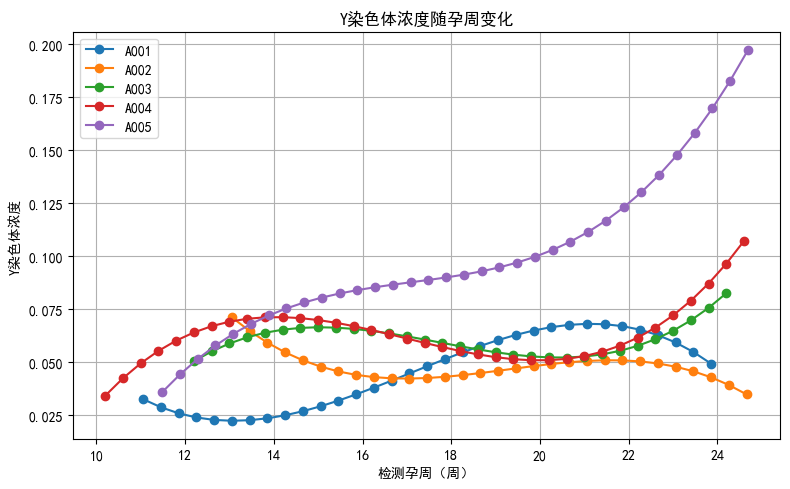

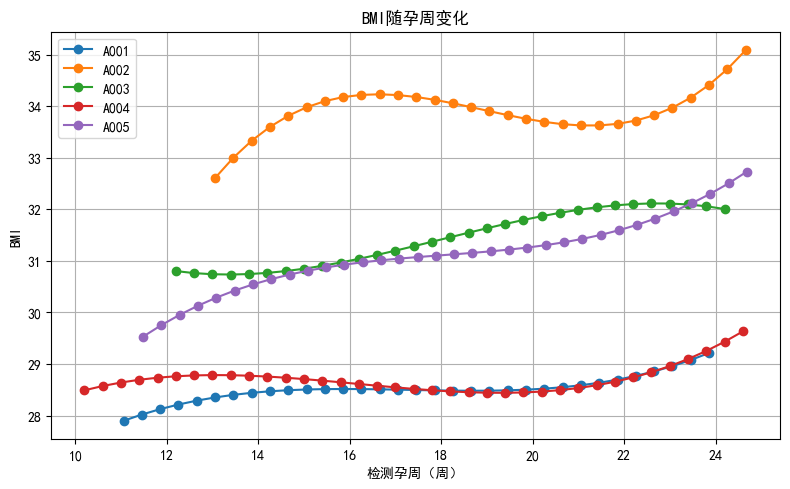

In [639]:
show_plts(result_df)

In [640]:
# 3. 找到每个孕妇的最早达标时间，同时显示BMI列
threshold = 0.04  # 4%
earliest_times = result_df[(result_df['Y染色体浓度'] >= threshold)] \
    .groupby('孕妇代码')[['检测孕周_周数','BMI']].min()
earliest_times

,检测孕周_周数,BMI
孕妇代码,,
A001,16.657143,28.481475
A002,13.057143,32.609722
A003,12.200000,30.736390
A004,10.600000,28.441281
A005,11.885714,29.756179
...,...,...
A263,11.771429,29.056635
A264,10.914286,32.442209
A265,10.914286,33.420051


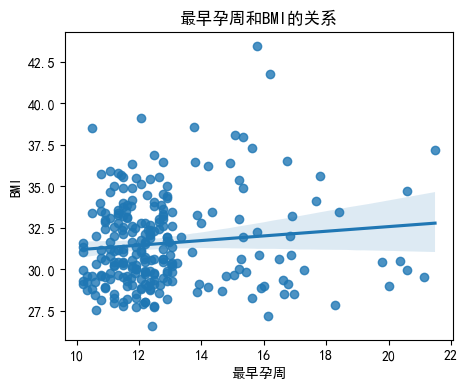

In [641]:
import matplotlib.pyplot as plt
import seaborn as sns
# 孕周和BMI的关系
plt.figure(figsize=(5, 4))
sns.regplot(x='检测孕周_周数', y='BMI', data=earliest_times)
plt.xlabel('最早孕周')
plt.ylabel('BMI')
plt.title('最早孕周和BMI的关系')
plt.show()


In [642]:
# 将孕周列重命名
earliest_times.rename(columns={'检测孕周_周数': '最早达标孕周'}, inplace=True)

print(earliest_times)


         最早达标孕周        BMI
孕妇代码                      
A001  16.657143  28.481475
A002  13.057143  32.609722
A003  12.200000  30.736390
A004  10.600000  28.441281
A005  11.885714  29.756179
...         ...        ...
A263  11.771429  29.056635
A264  10.914286  32.442209
A265  10.914286  33.420051
A266  12.914286  31.968138
A267  10.771429  30.693222

[251 rows x 2 columns]


In [643]:
df_unique = earliest_times.copy()
df_unique

,最早达标孕周,BMI
孕妇代码,,
A001,16.657143,28.481475
A002,13.057143,32.609722
A003,12.200000,30.736390
A004,10.600000,28.441281
A005,11.885714,29.756179
...,...,...
A263,11.771429,29.056635
A264,10.914286,32.442209
A265,10.914286,33.420051


### 聚类的参数

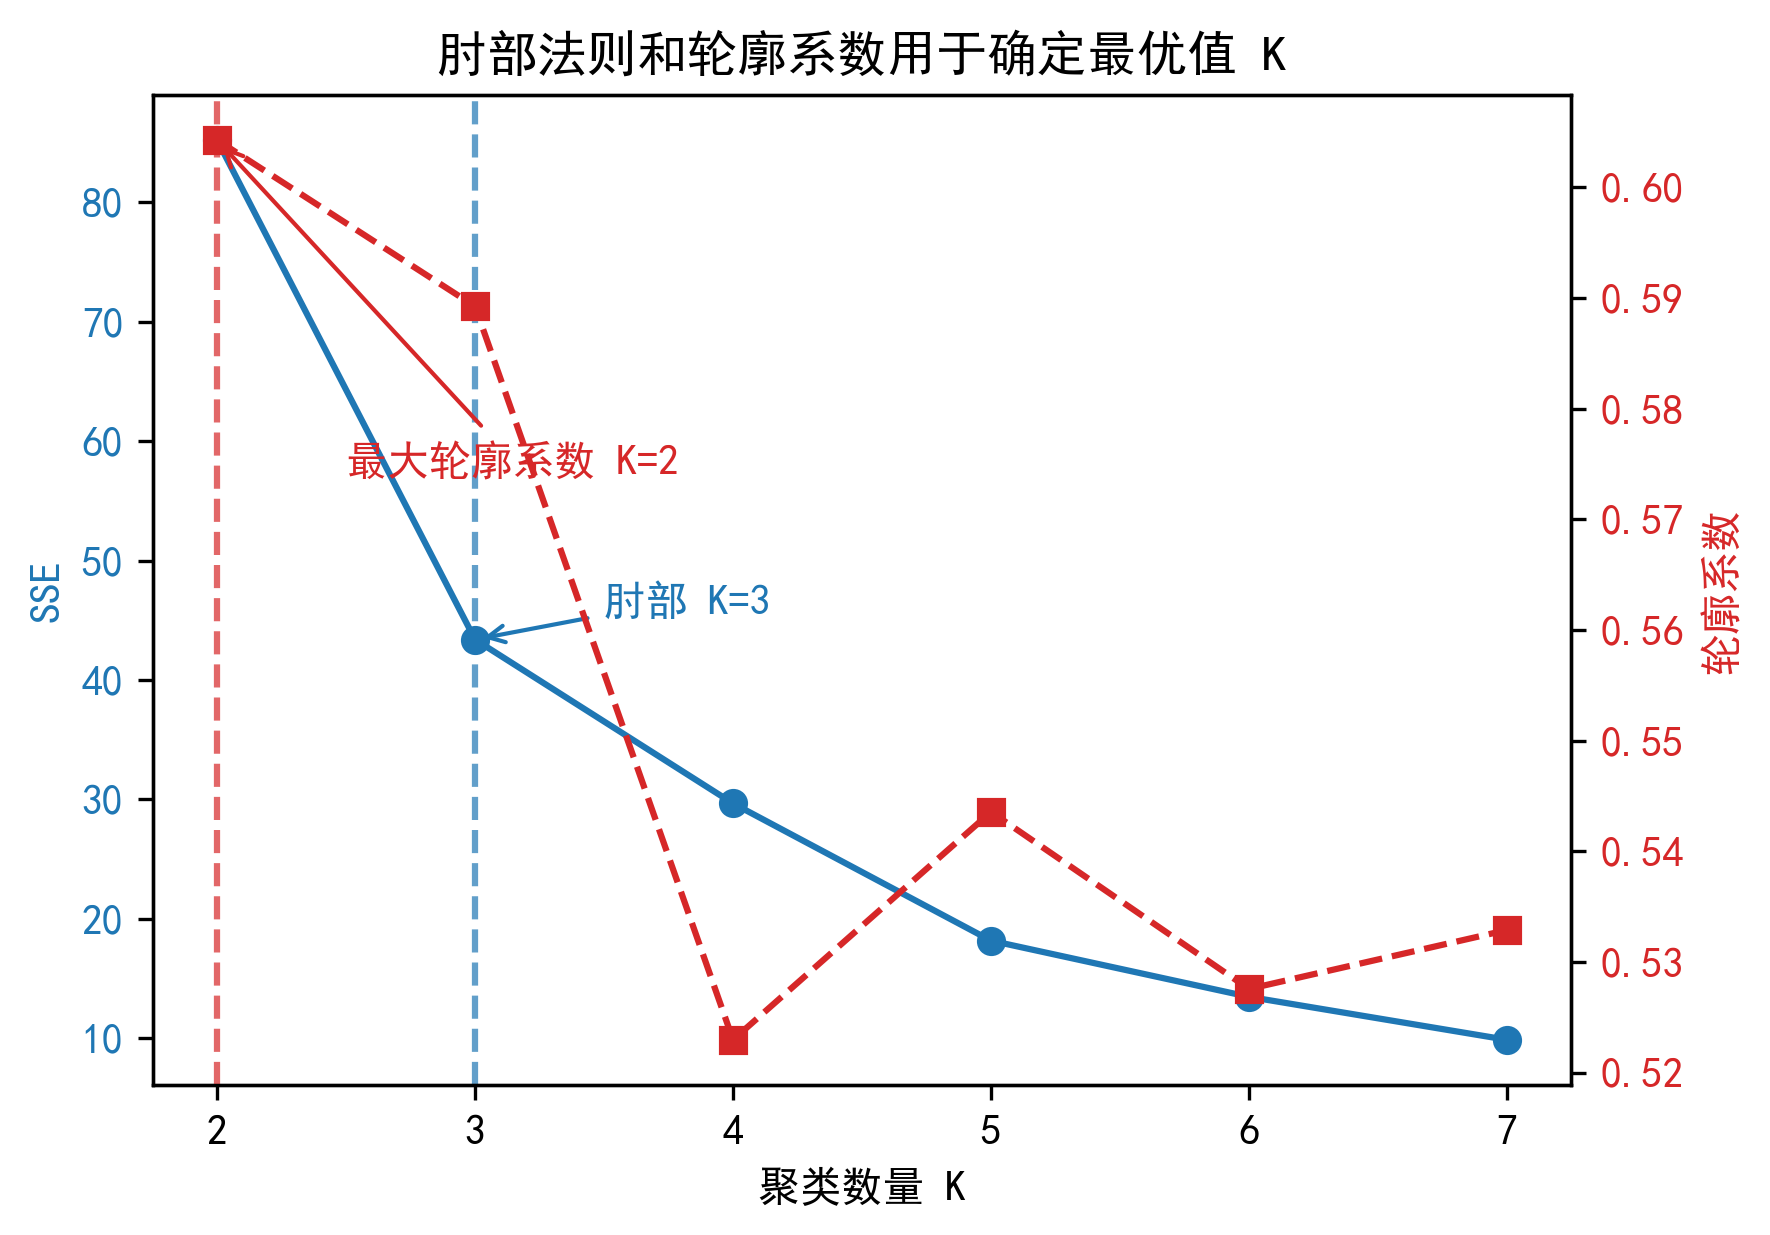

In [644]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import numpy as np


# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False



# ===== 1. 数据准备（标准化） =====
X = df_unique[['BMI']].values
X = (X - X.mean()) / X.std()

# ===== 2. 计算 SSE 和 轮廓系数 =====
sse = []
sil_scores = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=4,
        random_state=42,
        algorithm='elkan'
    )
    labels = km.fit_predict(X)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# ===== 3. 自动检测最佳 K =====
kl = KneeLocator(K_range, sse, curve="convex", direction="decreasing")
best_k_elbow = kl.knee
best_k_sil = K_range[np.argmax(sil_scores)]

fig, ax1 = plt.subplots(figsize=(6,4), dpi=300)

# 左轴 - SSE
color = 'tab:blue'
ax1.set_xlabel(r'聚类数量 K')
ax1.set_ylabel(r'SSE', color=color)
ax1.plot(K_range, sse, 'o-', color=color, label='SSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(best_k_elbow, color=color, linestyle='--', alpha=0.7)
ax1.annotate(fr'肘部 K={best_k_elbow}',
             xy=(best_k_elbow, sse[best_k_elbow-2]),
             xytext=(best_k_elbow+0.5, sse[best_k_elbow-2]*1.05),
             arrowprops=dict(arrowstyle='->', color=color),
             fontsize=10, color=color)

# 右轴 - Silhouette Score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'轮廓系数', color=color)
ax2.plot(K_range, sil_scores, 's--', color=color, label='轮廓系数')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axvline(best_k_sil, color=color, linestyle='--', alpha=0.7)
ax2.annotate(fr'最大轮廓系数 K={best_k_sil}',
             xy=(best_k_sil, sil_scores[best_k_sil-2]),
             xytext=(best_k_sil+0.5, sil_scores[best_k_sil-2]*0.95),
             arrowprops=dict(arrowstyle='->', color=color),
             fontsize=10, color=color)

# 图例
fig.tight_layout()
plt.title(r'肘部法则和轮廓系数用于确定最优值 K')
plt.savefig('optimal_k_plot.png', dpi=300, bbox_inches='tight')
plt.show()


选择3作为聚类的个数

In [645]:
K = 3
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# ===== 1. 数据准备（标准化） =====
X = df_unique[['BMI']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# ===== 2. KMeans 聚类（K=3） =====
kmeans = KMeans(
    n_clusters=K,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm='elkan'
)
labels = kmeans.fit_predict(X_scaled)
# ===== 3. 将聚类标签加入 DataFrame =====
df_unique['BMI_group'] = labels
# ===== 4. 聚类效果评估 =====
sil_score = silhouette_score(X_scaled, labels)
print(f"轮廓系数: {sil_score:.3f}")
# ===== 5. 分组统计（按 BMI 从小到大排序） =====
group_stats = df_unique.groupby('BMI_group')['BMI'].agg(
    min='min',
    max='max',
    mean='mean',
    size='count',
    std='std'
).sort_values('min')
print(group_stats)
# ===== 6. 如果你想按 BMI 从小到大重新编号分组 =====

轮廓系数: 0.589
                 min        max       mean  size       std
BMI_group                                                 
1          26.606024  31.089942  29.487075   130  0.963500
2          31.144389  34.635256  32.724538    88  0.931482
0          34.722222  43.488624  36.616755    33  1.959053


In [646]:
result_df

,孕妇代码,检测孕周_周数,BMI,Y染色体浓度
0,A001,11.057143,27.899025,0.032568
1,A001,11.457143,28.020243,0.028778
2,A001,11.857143,28.125000,0.025936
3,A001,12.257143,28.214425,0.023974
4,A001,12.657143,28.289647,0.022825
...,...,...,...,...
5848,A267,13.971429,31.270157,0.114337
5849,A267,14.371429,31.463587,0.119670
5850,A267,14.771429,31.689377,0.125895
5851,A267,15.171429,31.949062,0.133054


In [647]:
# 这时候df_unique已经是BMI分组后的了
df_unique_reset_index = df_unique.reset_index()
result_df = df_unique_reset_index.merge(result_df, on='孕妇代码')
result_df

,孕妇代码,最早达标孕周,BMI_x,BMI_group,检测孕周_周数,BMI_y,Y染色体浓度
0,A001,16.657143,28.481475,1,11.057143,27.899025,0.032568
1,A001,16.657143,28.481475,1,11.457143,28.020243,0.028778
2,A001,16.657143,28.481475,1,11.857143,28.125000,0.025936
3,A001,16.657143,28.481475,1,12.257143,28.214425,0.023974
4,A001,16.657143,28.481475,1,12.657143,28.289647,0.022825
...,...,...,...,...,...,...,...
5777,A267,10.771429,30.693222,1,13.971429,31.270157,0.114337
5778,A267,10.771429,30.693222,1,14.371429,31.463587,0.119670
5779,A267,10.771429,30.693222,1,14.771429,31.689377,0.125895
5780,A267,10.771429,30.693222,1,15.171429,31.949062,0.133054


In [648]:
# 将df_unique的BMI_group通过 孕妇代码 合并到 df 一致
df_merge = pd.merge(df, df_unique, on='孕妇代码', how='left')
df['BMI_group'] = df_merge['BMI_group']
df

,孕妇代码,检测孕周_周数,BMI,Y染色体浓度,BMI_group
0,A001,11.857143,28.125000,0.025936,1.0
1,A001,15.857143,28.515625,0.034887,1.0
2,A001,20.142857,28.515625,0.066171,1.0
3,A001,22.857143,28.906250,0.061192,1.0
4,A002,13.857143,33.331832,0.059230,2.0
...,...,...,...,...,...
882,A266,17.714286,32.969881,0.099052,2.0
883,A267,11.571429,30.703133,0.098706,1.0
884,A267,12.571429,30.825814,0.102088,1.0
885,A267,13.571429,31.107551,0.109855,1.0


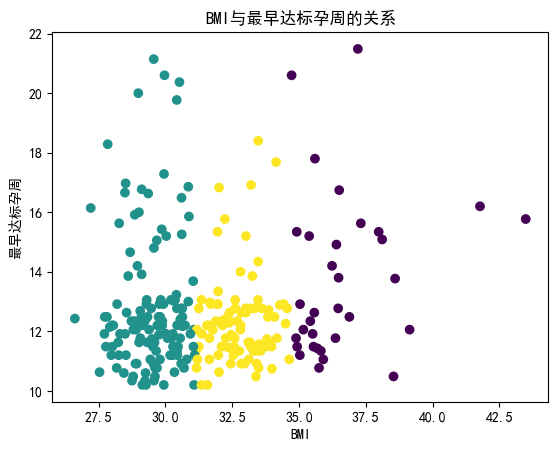

In [649]:


# 获取每组的位置
group_positions = df_unique.groupby('BMI_group').mean().sort_values('BMI')['BMI'].index

# 绘制散点图
plt.scatter(df_unique['BMI'], df_unique['最早达标孕周'], c=df_unique['BMI_group'], cmap='viridis')

# 绘制聚类中心
#plt.scatter(group_positions, df_unique.groupby('BMI_group').mean().sort_values('BMI')['最早达标孕周'], marker='x', s=100, c='red')

# 添加标签
plt.xlabel('BMI')
plt.ylabel('最早达标孕周')
plt.title('BMI与最早达标孕周的关系')

# 显示图形
plt.show()


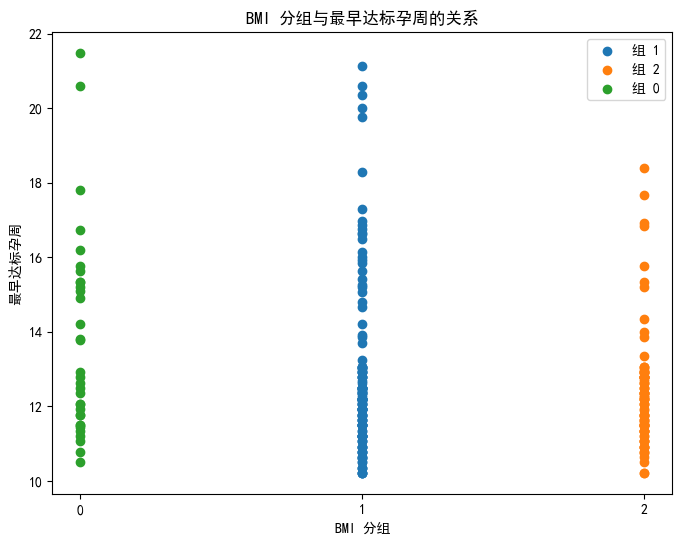

In [650]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 获取分组编号（假设 BMI_group 是整数 0,1,2,...）
groups = df_unique['BMI_group'].unique()

plt.figure(figsize=(8,6))
for g in groups:
    group_data = df_unique[df_unique['BMI_group'] == g]
    # 横坐标全是组编号 g
    plt.scatter([g]*len(group_data), group_data['最早达标孕周'], label=f'组 {g}')

plt.xticks(groups)  # 横坐标显示组编号
plt.xlabel('BMI 分组')
plt.ylabel('最早达标孕周')
plt.title('BMI 分组与最早达标孕周的关系')
plt.legend()
plt.show()


In [651]:
import numpy as np
import pandas as pd

def find_best_time(group_data, delta=2, w1=0.6, w2=0.4):
    weeks = np.arange(9, 20, 0.1)  # 枚举检测孕周
    risks = []
    for t in weeks:
        early_risk = np.mean(group_data > t)       # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        risks.append(total_risk)
    best_idx = np.argmin(risks)
    return weeks[best_idx], risks[best_idx]

# 假设 df_unique 有 BMI_group 和 最早达标孕周
best_times = []
for g, sub in df_unique.groupby('BMI_group'):
    best_t, min_risk = find_best_time(sub['最早达标孕周'].values)
    best_times.append({
        'BMI_group': g,
        'BMI_min': sub['BMI'].min(),
        'BMI_max': sub['BMI'].max(),
        '最佳孕周': best_t,
        '最小风险值': min_risk
    })

best_times_df = pd.DataFrame(best_times)
print(best_times_df)


   BMI_group    BMI_min    BMI_max  最佳孕周     最小风险值
0          0  34.722222  43.488624  13.0  0.296970
1          1  26.606024  31.089942  13.1  0.207692
2          2  31.144389  34.635256  13.1  0.143182


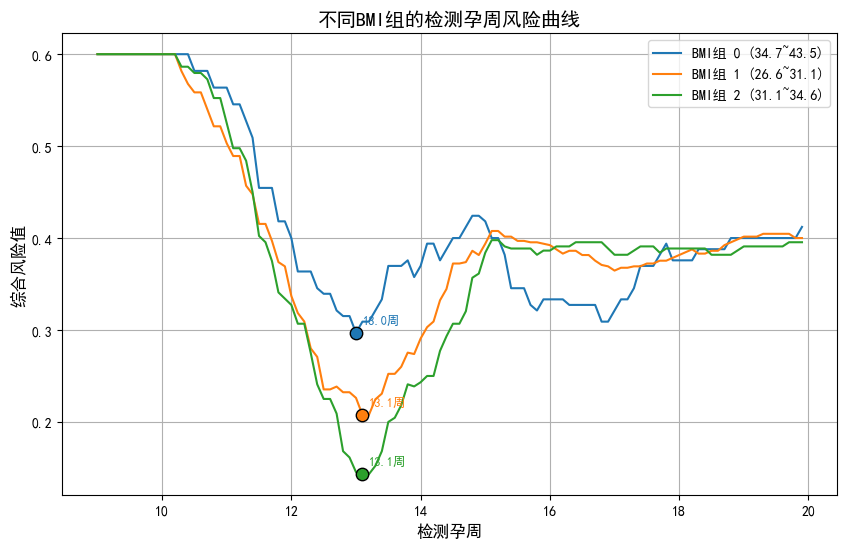

,BMI_group,BMI_min,BMI_max,最佳孕周,最小风险值
0,0,34.722222,43.488624,13.0,0.296970
1,1,26.606024,31.089942,13.1,0.207692
2,2,31.144389,34.635256,13.1,0.143182


In [652]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 风险计算函数
# ---------------------------
def find_best_time_curve(group_data, delta=2, w1=0.6, w2=0.4):
    """
    输入：
        group_data: 该BMI组的最早达标孕周数组
        delta: 晚检延迟阈值（周）
        w1, w2: 早检风险与晚检风险权重
    输出：
        weeks: 孕周数组
        risks: 对应风险值数组
        best_t: 最佳孕周
        min_risk: 最小风险值
    """
    weeks = np.arange(9, 20, 0.1)  # 枚举检测孕周
    risks = []
    for t in weeks:
        early_risk = np.mean(group_data > t)       # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        risks.append(total_risk)
    risks = np.array(risks)
    best_idx = np.argmin(risks)
    return weeks, risks, weeks[best_idx], risks[best_idx]

# ---------------------------
# 绘制风险曲线
# ---------------------------
plt.figure(figsize=(10, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 每组颜色
best_points = []

for i, (g, sub) in enumerate(df_unique.groupby('BMI_group')):
    weeks, risks, best_t, min_risk = find_best_time_curve(sub['最早达标孕周'].values)
    plt.plot(weeks, risks, label=f'BMI组 {g} ({sub["BMI"].min():.1f}~{sub["BMI"].max():.1f})', color=colors[i])
    plt.scatter(best_t, min_risk, color=colors[i], s=80, edgecolors='k', zorder=5)
    plt.text(best_t+0.1, min_risk+0.01, f'{best_t:.1f}周', fontsize=9, color=colors[i])
    best_points.append((g, sub["BMI"].min(), sub["BMI"].max(), best_t, min_risk))

plt.xlabel('检测孕周', fontsize=12)
plt.ylabel('综合风险值', fontsize=12)
plt.title('不同BMI组的检测孕周风险曲线', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 输出最佳孕周表格
# ---------------------------
best_df = pd.DataFrame(best_points, columns=['BMI_group', 'BMI_min', 'BMI_max', '最佳孕周', '最小风险值'])
display(best_df)


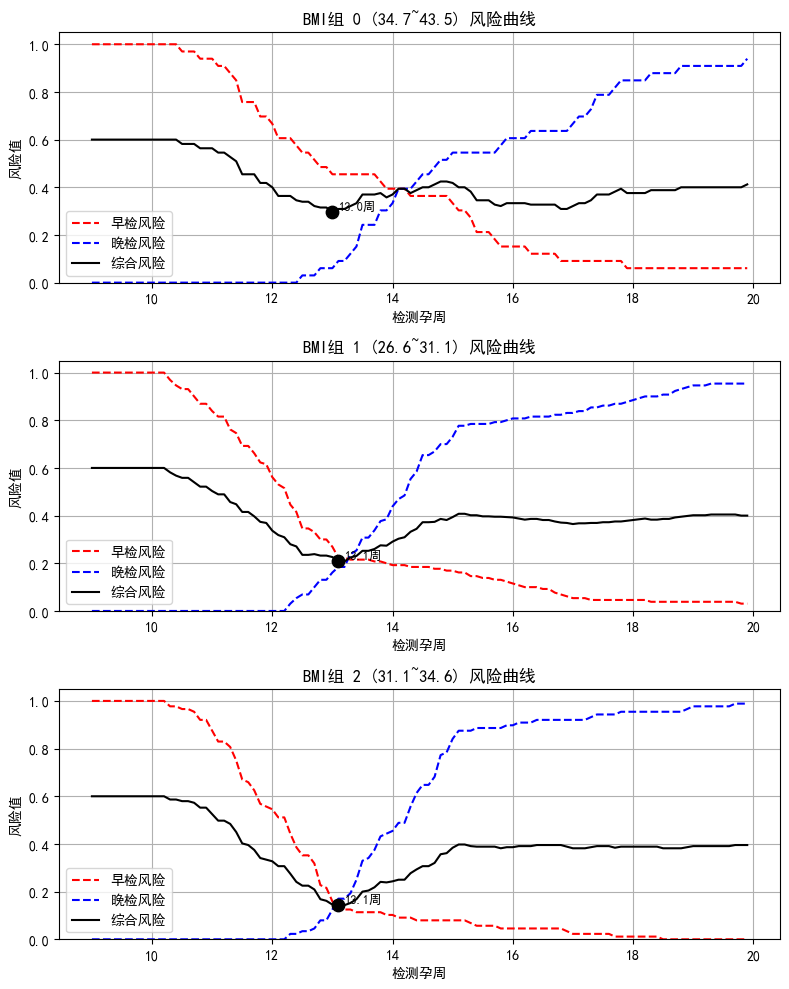

,BMI_group,BMI_min,BMI_max,最佳孕周,最小风险值
0,0,34.722222,43.488624,13.0,0.296970
1,1,26.606024,31.089942,13.1,0.207692
2,2,31.144389,34.635256,13.1,0.143182


In [653]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 风险计算函数（返回分解曲线）
# ---------------------------
def find_best_time_curve_detail(group_data, delta=2, w1=0.6, w2=0.4):
    weeks = np.arange(9, 20, 0.1)  # 检测孕周范围
    early_risks = []
    late_risks = []
    total_risks = []
    
    for t in weeks:
        early_risk = np.mean(group_data > t)        # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        
        early_risks.append(early_risk)
        late_risks.append(late_risk)
        total_risks.append(total_risk)
    
    early_risks = np.array(early_risks)
    late_risks = np.array(late_risks)
    total_risks = np.array(total_risks)
    
    best_idx = np.argmin(total_risks)
    return weeks, early_risks, late_risks, total_risks, weeks[best_idx], total_risks[best_idx]

# ---------------------------
# 绘制每个BMI组的风险分解曲线
# ---------------------------
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
best_points = []


fig, axs = plt.subplots(len(df_unique.BMI_group.unique()), 1, figsize=(8, 10))
for i, (g, sub) in enumerate(df_unique.groupby('BMI_group')):
    weeks, early_risks, late_risks, total_risks, best_t, min_risk = find_best_time_curve_detail(
        sub['最早达标孕周'].values
    )
    
    axs[i].plot(weeks, early_risks, '--', color='red', label='早检风险')
    axs[i].plot(weeks, late_risks, '--', color='blue', label='晚检风险')
    axs[i].plot(weeks, total_risks, '-', color='black', label='综合风险')
    
    # 标注最佳孕周
    axs[i].scatter(best_t, min_risk, color='black', s=80, edgecolors='k', zorder=5)
    axs[i].text(best_t+0.1, min_risk+0.01, f'{best_t:.1f}周', fontsize=9, color='black')
    
    axs[i].set_title(f'BMI组 {g} ({sub["BMI"].min():.1f}~{sub["BMI"].max():.1f}) 风险曲线')
    axs[i].set_xlabel('检测孕周')
    axs[i].set_ylabel('风险值')
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(True)
    axs[i].legend()
    best_points.append((g, sub["BMI"].min(), sub["BMI"].max(), best_t, min_risk))

plt.tight_layout()
plt.show()

# ---------------------------
# 输出最佳孕周表格
# ---------------------------
best_df = pd.DataFrame(best_points, columns=['BMI_group', 'BMI_min', 'BMI_max', '最佳孕周', '最小风险值'])
display(best_df)


把之前的 启发式风险模型 升级为 分布拟合 + 风险最小化 的版本

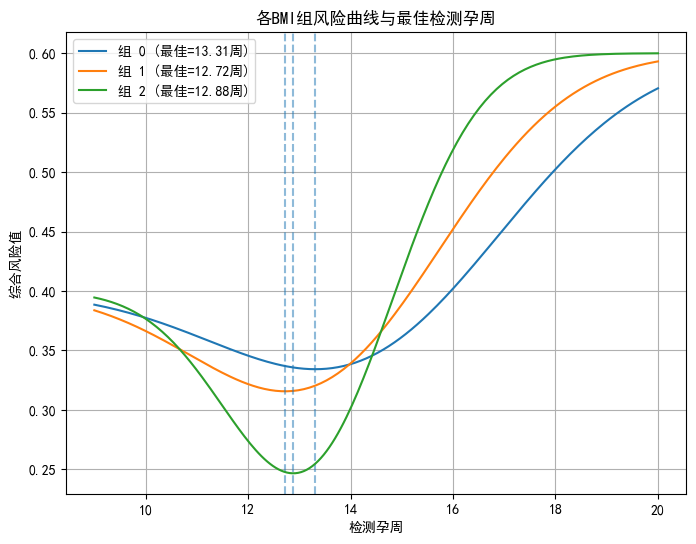

,BMI_group,BMI_min,BMI_max,μ孕周,σ孕周,最佳孕周
0,0,34.722222,43.488624,13.753247,2.665177,13.313204
1,1,26.606024,31.089942,12.802198,2.305229,12.724861
2,2,31.144389,34.635256,12.355844,1.528613,12.882128


In [666]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

def best_time_for_group(weeks, delta=2, w1=0.4, w2=0.6):
    # 正态分布拟合
    mu, sigma = norm.fit(weeks)
    
    # 风险函数
    def risk(t):
        early_risk = 1 - norm.cdf(t, mu, sigma)      # 未达标概率
        late_risk = norm.cdf(t - delta, mu, sigma)   # 延误概率
        return w1 * early_risk + w2 * late_risk
    
    # 最优孕周搜索
    res = minimize_scalar(risk, bounds=(9, 20), method='bounded')
    return res.x, mu, sigma, risk

results = []
plt.figure(figsize=(8,6))

for g, sub in df_unique.groupby('BMI_group'):
    t_opt, mu, sigma, risk_func = best_time_for_group(sub['最早达标孕周'].values)
    results.append({
        'BMI_group': g,
        'BMI_min': sub['BMI'].min(),
        'BMI_max': sub['BMI'].max(),
        'μ孕周': mu,
        'σ孕周': sigma,
        '最佳孕周': t_opt
    })
    
    # 绘制风险曲线
    weeks_range = np.linspace(9, 20, 200)
    risks = [risk_func(t) for t in weeks_range]
    plt.plot(weeks_range, risks, label=f'组 {g} (最佳={t_opt:.2f}周)')
    plt.axvline(t_opt, linestyle='--', alpha=0.5)

plt.xlabel('检测孕周')
plt.ylabel('综合风险值')
plt.title('各BMI组风险曲线与最佳检测孕周')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
results_df


增加阶段风险：

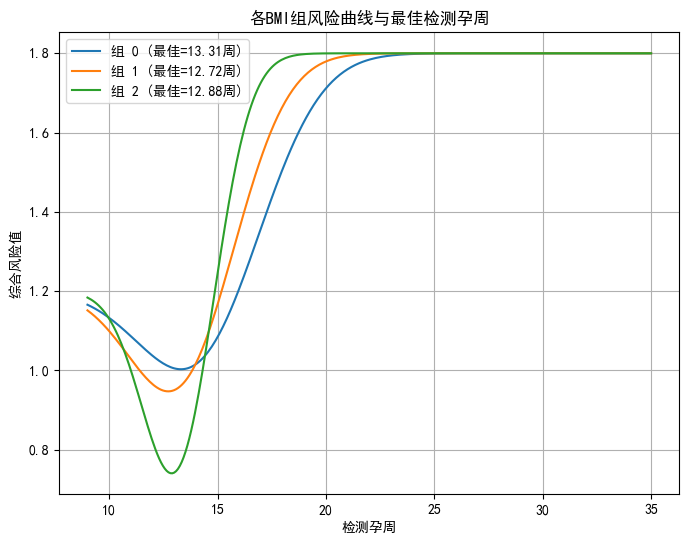

组 0 (BMI区间[34.72-43.49]): 最佳检测孕周为13.31周
组 1 (BMI区间[26.61-31.09]): 最佳检测孕周为12.72周
组 2 (BMI区间[31.14-34.64]): 最佳检测孕周为12.88周


In [675]:
def best_time_for_group_with_stage(weeks, delta=2, w1=0.4, w2=0.6):
    mu, sigma = norm.fit(weeks)
    
    def stage_risk_weight(t):
        a = 1.0
        b = 3.0
        x = np.minimum(t, 12)
        x = np.maximum(x, 27)
        return a + (b - a) * (x - 12) / (27 - 12)
    
    def risk(t):
        early_risk = 1 - norm.cdf(t, mu, sigma)
        late_risk = norm.cdf(t - delta, mu, sigma)
        base_risk = w1 * early_risk + w2 * late_risk
        return stage_risk_weight(t) * base_risk
    
    res = minimize_scalar(risk, bounds=(9, 35), method='bounded')
    return res.x, mu, sigma, risk
results = []
plt.figure(figsize=(8,6))
for g, sub in df_unique.groupby('BMI_group'):
    t_opt, mu, sigma, risk_func = best_time_for_group_with_stage(sub['最早达标孕周'].values)
    results.append({
        'BMI_group': g,
        'BMI_min': sub['BMI'].min(),
        'BMI_max': sub['BMI'].max(),
        'μ孕周': mu,
        'σ孕周': sigma,
        '最佳孕周': t_opt
    })
    
    weeks_range = np.linspace(9, 35, 300)
    risks = [risk_func(t) for t in weeks_range]
    plt.plot(weeks_range, risks, label=f'组 {g} (最佳={t_opt:.2f}周)')
plt.xlabel('检测孕周')
plt.ylabel('综合风险值')
plt.title('各BMI组风险曲线与最佳检测孕周')
plt.legend()
plt.grid(True)
plt.show()


# 打印每个组的最佳实践
for item in results:
    print(f"组 {item['BMI_group']} (BMI区间[{item['BMI_min']:.2f}-{item['BMI_max']:.2f}]): 最佳检测孕周为{item['最佳孕周']:.2f}周")


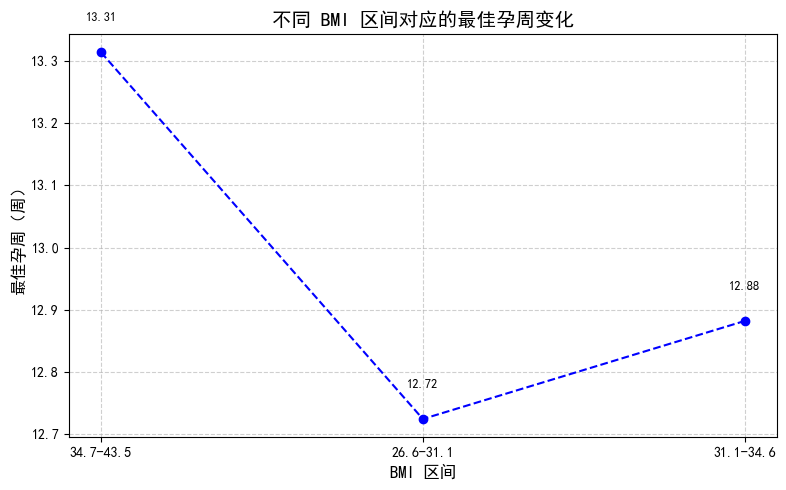

In [655]:
import matplotlib.pyplot as plt
import pandas as pd


df = results_df.copy()

# 生成 BMI 区间标签
df['BMI_range'] = df.apply(lambda x: f"{x['BMI_min']:.1f}-{x['BMI_max']:.1f}", axis=1)

# 绘图
plt.figure(figsize=(8,5))
plt.plot(df['BMI_range'], df['最佳孕周'], marker='o', linestyle='dashed', color='b')

# 添加数据标签
for i, val in enumerate(df['最佳孕周']):
    plt.text(i, val+0.05, f"{val:.2f}", ha='center', fontsize=9)

# 设置标题和标签
plt.title("不同 BMI 区间对应的最佳孕周变化", fontsize=14)
plt.xlabel("BMI 区间", fontsize=12)
plt.ylabel("最佳孕周（周）", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 蒙特卡洛模拟v2

In [670]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_opt_analysis(weeks, err_sigma=1.0, n_sim=500, random_state=None):
    """
    蒙特卡洛模拟检测误差对最优孕周的影响
    
    参数：
    weeks : array-like
        原始孕周数据
    err_sigma : float
        孕周测量误差的标准差（单位：周）
    n_sim : int
        模拟次数
    random_state : int or None
        随机种子，便于复现
    
    返回：
    mean_t : float
        模拟得到的最优孕周均值
    std_t : float
        模拟得到的最优孕周标准差
    t_opts : list
        每次模拟的最优孕周
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    t_opts = []
    for _ in range(n_sim):
        # 在原始孕周数据上加入测量误差
        noisy_weeks = weeks + np.random.normal(0, err_sigma, size=len(weeks))
        # 重新计算最优孕周
        t_opt, _, _, _ = best_time_for_group_with_stage(noisy_weeks)
        t_opts.append(t_opt)
    
    mean_t = np.mean(t_opts)
    std_t = np.std(t_opts)
    
    # 绘制分布直方图
    plt.figure(figsize=(7,5))
    plt.hist(t_opts, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
    plt.axvline(mean_t, color='red', linestyle='--', label=f'均值={mean_t:.2f}周')
    plt.xlabel('最优孕周')
    plt.ylabel('频数')
    plt.title(f'蒙特卡洛模拟（误差σ={err_sigma}周, 次数={n_sim}）')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"误差σ={err_sigma} 周：")
    print(f"  平均最优孕周 = {mean_t:.2f} 周")
    print(f"  标准差       = {std_t:.2f} 周")
    
    return mean_t, std_t, t_opts


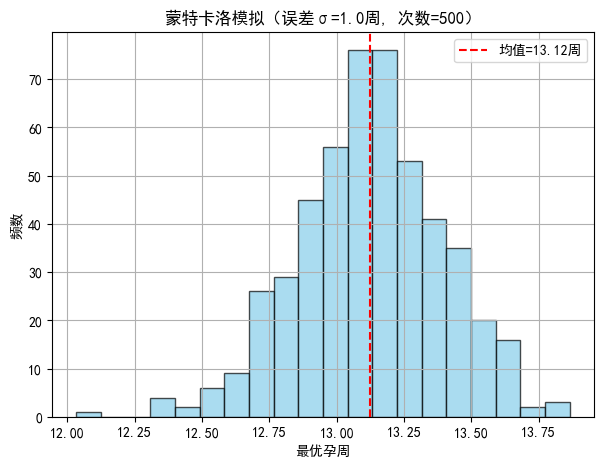

误差σ=1.0 周：
  平均最优孕周 = 13.12 周
  标准差       = 0.27 周


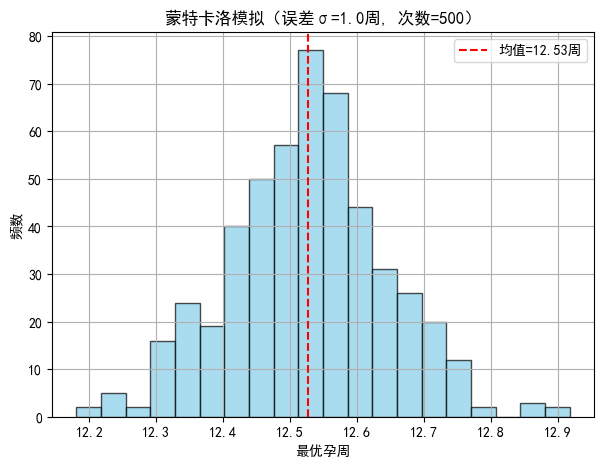

误差σ=1.0 周：
  平均最优孕周 = 12.53 周
  标准差       = 0.12 周


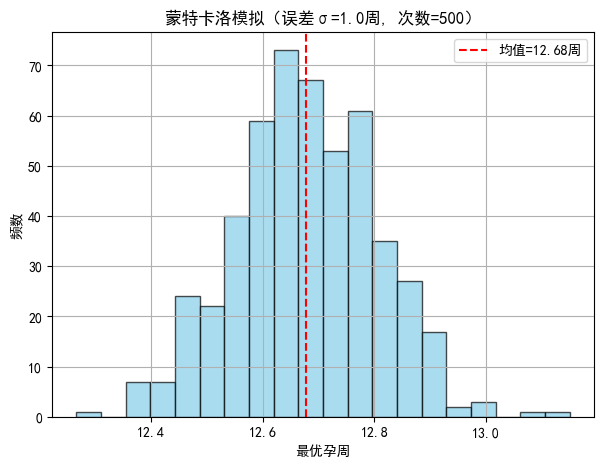

误差σ=1.0 周：
  平均最优孕周 = 12.68 周
  标准差       = 0.13 周


In [677]:
for i in range(0,3):
    # 取一个 BMI 组的数据
    weeks_data = df_unique[df_unique['BMI_group'] == i]['最早达标孕周'].values

    # 模拟误差 σ=1 周，重复 500 次
    mean_t, std_t, t_list = monte_carlo_opt_analysis(weeks_data, err_sigma=1.0, n_sim=500, random_state=42)


### 误差水平敏感性分析

In [678]:
def error_sensitivity_analysis(weeks, err_sigma_list, n_sim=500, random_state=None):
    """
    对不同检测误差水平进行敏感性分析
    
    参数：
    weeks : array-like
        原始孕周数据
    err_sigma_list : list
        检测误差标准差列表（单位：周）
    n_sim : int
        每个误差水平的模拟次数
    random_state : int or None
        随机种子
    
    返回：
    results : list of dict
        每个误差水平的均值、标准差
    """
    results = []
    for sigma in err_sigma_list:
        mean_t, std_t, _ = monte_carlo_opt_analysis(
            weeks, err_sigma=sigma, n_sim=n_sim, random_state=random_state
        )
        results.append({
            'err_sigma': sigma,
            'mean_t_opt': mean_t,
            'std_t_opt': std_t
        })
    
    # 绘制趋势图
    sigmas = [r['err_sigma'] for r in results]
    means = [r['mean_t_opt'] for r in results]
    stds  = [r['std_t_opt'] for r in results]
    
    plt.figure(figsize=(8,5))
    plt.errorbar(sigmas, means, yerr=stds, fmt='-o', capsize=5, label='最优孕周 ± 标准差')
    plt.xlabel('检测误差标准差 σ (周)')
    plt.ylabel('最优孕周 (周)')
    plt.title('检测误差对最优孕周的敏感性分析')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return results


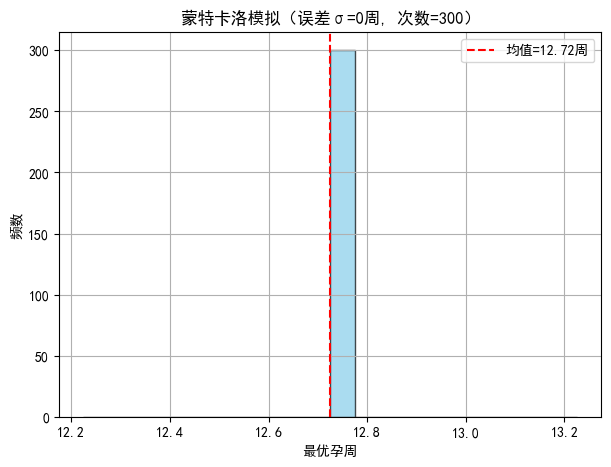

误差σ=0 周：
  平均最优孕周 = 12.72 周
  标准差       = 0.00 周


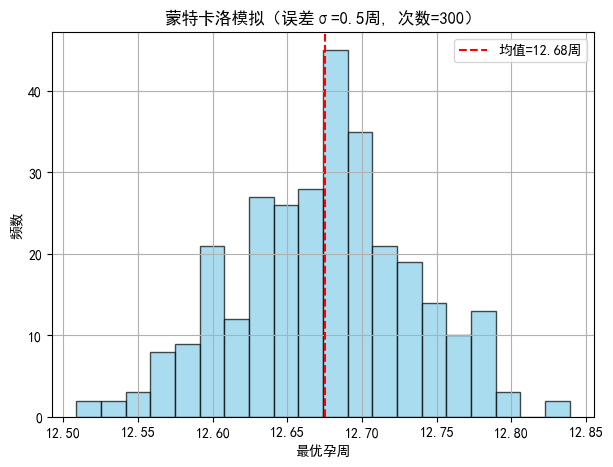

误差σ=0.5 周：
  平均最优孕周 = 12.68 周
  标准差       = 0.06 周


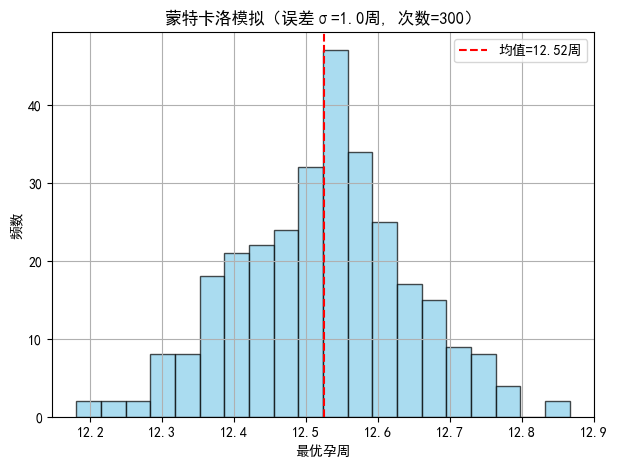

误差σ=1.0 周：
  平均最优孕周 = 12.52 周
  标准差       = 0.12 周


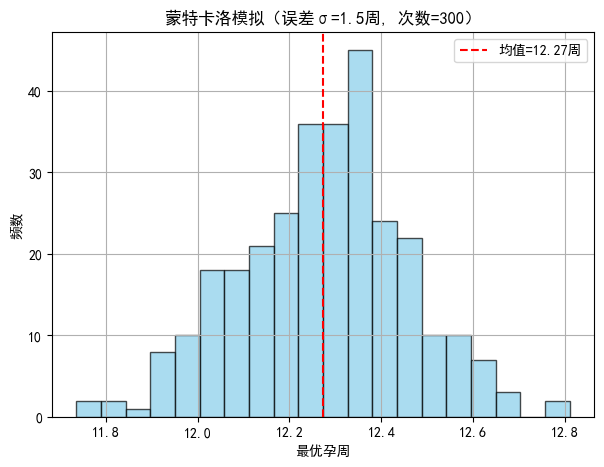

误差σ=1.5 周：
  平均最优孕周 = 12.27 周
  标准差       = 0.18 周


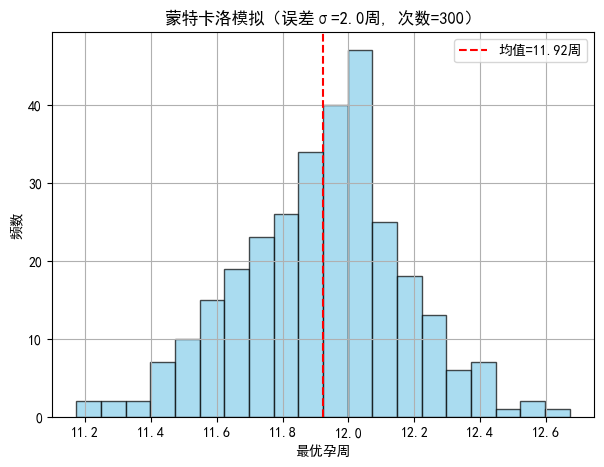

误差σ=2.0 周：
  平均最优孕周 = 11.92 周
  标准差       = 0.25 周


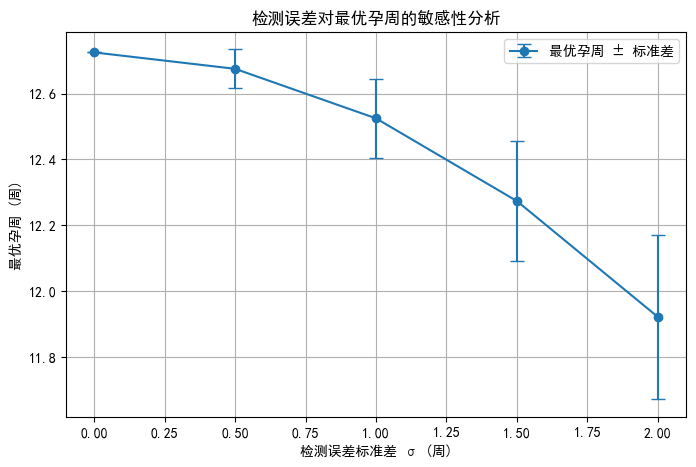

,err_sigma,mean_t_opt,std_t_opt
0,0.0,12.724860,0.000000
1,0.5,12.675072,0.059263
2,1.0,12.524621,0.119368
3,1.5,12.273509,0.182358
4,2.0,11.921735,0.250133


In [679]:
# 取一个 BMI 组的数据
weeks_data = df_unique[df_unique['BMI_group'] == 1]['最早达标孕周'].values
# 定义不同的检测误差水平（单位：周）
err_sigma_list = [0, 0.5, 1.0, 1.5, 2.0]
# 批量运行敏感性分析
results = error_sensitivity_analysis(weeks_data, err_sigma_list, n_sim=300, random_state=42)
# 输出结果表格
import pandas as pd
pd.DataFrame(results)

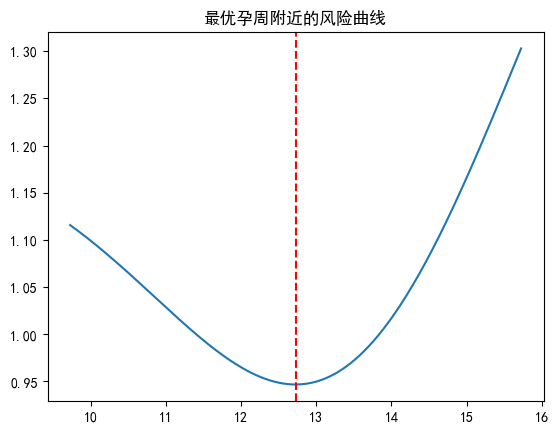

In [683]:
t_opt, mu, sigma, risk_func = best_time_for_group_with_stage(weeks_data)
t_range = np.linspace(t_opt-3, t_opt+3, 200)
plt.plot(t_range, [risk_func(t) for t in t_range])
plt.axvline(t_opt, color='red', linestyle='--')
plt.title('最优孕周附近的风险曲线')
plt.show()

### 拟合

In [656]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 线性模型
def linear_model(t, alpha, beta):
    return alpha * t + beta

# Logistic 模型
def logistic_model(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def fit_growth_curve(df, model_type='linear'):
    results = []
    plt.figure(figsize=(10,6))
    
    for g, sub in df.groupby('BMI_group'):
        t = sub['检测孕周_周数'].values
        y = sub['Y染色体浓度'].values
        
        if model_type == 'linear':
            popt, _ = curve_fit(linear_model, t, y)
            alpha, beta = popt
            results.append({'BMI_group': g, 'alpha': alpha, 'beta': beta})
            t_fit = np.linspace(min(t), max(t), 100)
            y_fit = linear_model(t_fit, alpha, beta)
        
        elif model_type == 'logistic':
            # 初始猜测参数
            p0 = [max(y), 1, np.median(t)]
            popt, _ = curve_fit(logistic_model, t, y, p0=p0, maxfev=10000)
            L, k, t0 = popt
            results.append({'BMI_group': g, 'L': L, 'k': k, 't0': t0})
            t_fit = np.linspace(min(t), max(t), 100)
            y_fit = logistic_model(t_fit, L, k, t0)
        
        plt.scatter(t, y, label=f'组 {g} 数据')
        plt.plot(t_fit, y_fit, label=f'组 {g} 拟合曲线')
    
    plt.xlabel('孕周')
    plt.ylabel('Y染色体浓度')
    plt.title(f'各 BMI 组 Y 浓度增长曲线 ({model_type} 模型)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pd.DataFrame(results)


In [657]:
result_df

,孕妇代码,最早达标孕周,BMI_x,BMI_group,检测孕周_周数,BMI_y,Y染色体浓度
0,A001,16.657143,28.481475,1,11.057143,27.899025,0.032568
1,A001,16.657143,28.481475,1,11.457143,28.020243,0.028778
2,A001,16.657143,28.481475,1,11.857143,28.125000,0.025936
3,A001,16.657143,28.481475,1,12.257143,28.214425,0.023974
4,A001,16.657143,28.481475,1,12.657143,28.289647,0.022825
...,...,...,...,...,...,...,...
5777,A267,10.771429,30.693222,1,13.971429,31.270157,0.114337
5778,A267,10.771429,30.693222,1,14.371429,31.463587,0.119670
5779,A267,10.771429,30.693222,1,14.771429,31.689377,0.125895
5780,A267,10.771429,30.693222,1,15.171429,31.949062,0.133054


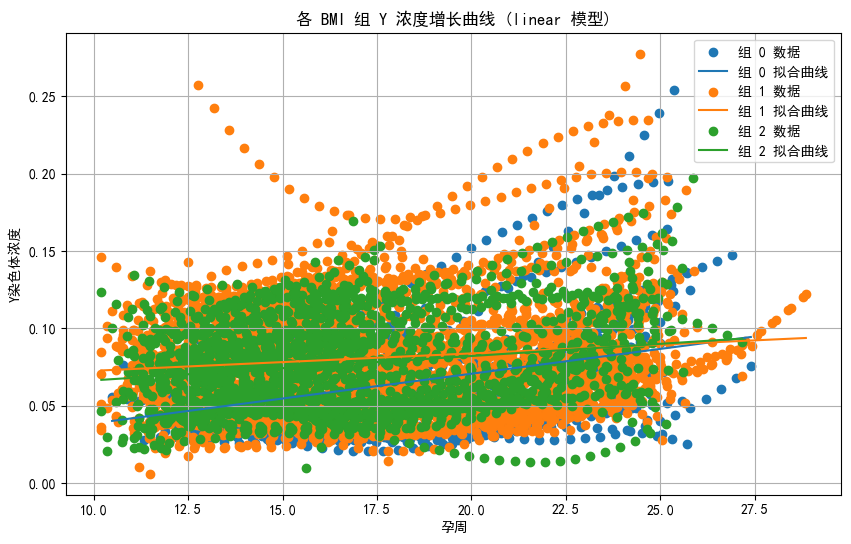

   BMI_group     alpha      beta
0          0  0.003208  0.006437
1          1  0.001125  0.061238
2          2  0.001573  0.050581


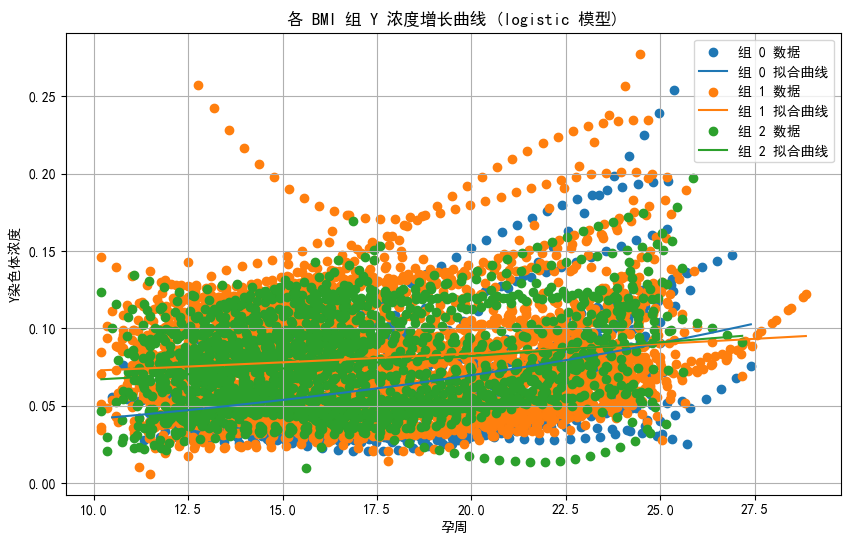

   BMI_group           L         k          t0
0          0  334.527289  0.052256  182.215311
1          1   22.673850  0.014294  411.609983
2          2   47.979631  0.020654  328.405765


In [658]:
# 选择线性拟合
fit_results_linear = fit_growth_curve(result_df, model_type='linear')
print(fit_results_linear)
# 如果线性效果不好，可以试 Logistic
fit_results_logistic = fit_growth_curve(result_df, model_type='logistic')
print(fit_results_logistic)

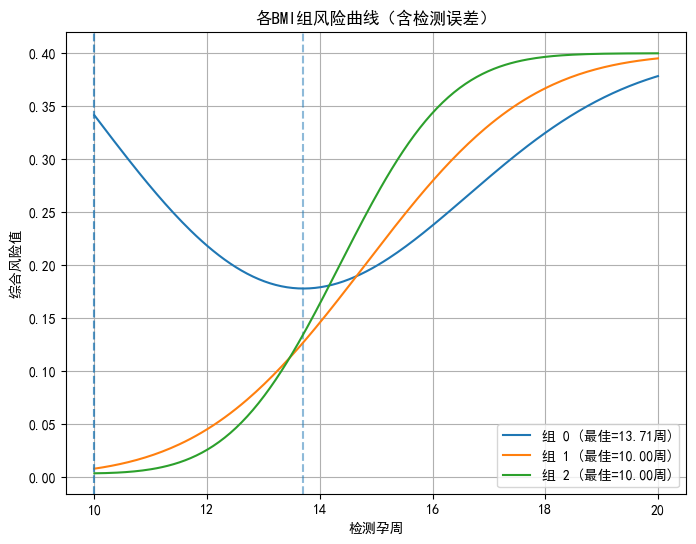

   BMI_group    BMI_min    BMI_max        μ孕周       σ孕周       最佳孕周
0          0  34.722222  43.488624  13.753247  2.665177  13.709728
1          1  26.606024  31.089942  12.802198  2.305229  10.000005
2          2  31.144389  34.635256  12.355844  1.528613  10.000005


In [664]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# 你的线性模型参数
alpha_beta_dict = {
    0.0: (fit_results_linear['alpha'][0], fit_results_linear['beta'][0]),
    1.0: (fit_results_linear['alpha'][1]  , fit_results_linear['beta'][1]),
    2.0: (fit_results_linear['alpha'][2], fit_results_linear['beta'][2])
}

# 风险优化函数
def monte_carlo_best_time(weeks, alpha, beta, sigma_eps=0.001, delta=2, w1=0.6, w2=0.4):
    mu, sigma = norm.fit(weeks)  # 孕周分布拟合
    
    def risk(t):
        # 早检风险（含噪声概率计算）
        pass_prob = 1 - norm.cdf((0.04 - (alpha * t + beta)) / sigma_eps)
        early_risk = 1 - pass_prob
        
        # 晚检风险（孕周分布）
        late_risk = norm.cdf(t - delta, mu, sigma)
        
        return w1 * early_risk + w2 * late_risk
    
    res = minimize_scalar(risk, bounds=(10, 20), method='bounded')
    return res.x, mu, sigma, risk

# 运行模型
results = []
plt.figure(figsize=(8,6))

for g, sub in df_unique.groupby('BMI_group'):
    alpha, beta = alpha_beta_dict[g]
    t_opt, mu, sigma, risk_func = monte_carlo_best_time(
        sub['最早达标孕周'].values,
        alpha=alpha,
        beta=beta,
        sigma_eps=0.01
    )
    results.append({
        'BMI_group': g,
        'BMI_min': sub['BMI'].min(),
        'BMI_max': sub['BMI'].max(),
        'μ孕周': mu,
        'σ孕周': sigma,
        '最佳孕周': t_opt
    })
    
    weeks_range = np.linspace(10, 20, 200)
    risks = [risk_func(t) for t in weeks_range]
    plt.plot(weeks_range, risks, label=f'组 {g} (最佳={t_opt:.2f}周)')
    plt.axvline(t_opt, linestyle='--', alpha=0.5)

plt.xlabel('检测孕周')
plt.ylabel('综合风险值')
plt.title('各BMI组风险曲线（含检测误差）')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
print(results_df)
